## Pitch Predict: English Premier League Match Results Prediction

## Introduction

In this project, we compare the performance of many Machine Learning and Deep Learning strategies and models to predict the outcomes of English Premier League soccer matches based on the average player performance of both teams from the previous season (mormalized by minutes played). We have two targets for prediction: the result (Home Win, Away Win, or Draw), as well as the Goal Difference for the home team (home goals - away goals). This allows us to perform both classification and regression, to have a greater chance at discovering the best predictor model possible.

The goal is to have the best model (that is within our means to achieve) to **predict the result of an EPL match based only on the team sheets (player list) for the Home and Away teams.** This could be useful for betting, fantasy sports, or other applications where predicting the outcome of a match based on limited, but fast and readily available information is important.

Both traditional machine learning and basic deep learning techniques will be used. To ensure a rigorous assessment, we will employ pipelines for hyperparameter tuning, and k-fold cross-validation for validating model performance. We will also create different neural network models, such as a basic fully connected NN, an Tabular CNN, or other neural network strategies, and compare their accuracy metrics. This methodology will give us an exhaustive exploration of a wide array of models for the selection of a model that best captures the match outcomes.

### Data Sources
*Click to follow links.*

Match Statistics: [matches.jsonl](https://www.kaggle.com/datasets/hugomathien/soccer/data) and [players.csv](https://www.kaggle.com/datasets/hugomathien/soccer/data)

Player Statistics: [All Files in player_statistics folder](https://www.kaggle.com/datasets/davidantonioteixeira/premier-league-player-statistics-1992-2022?resource=download)


### Training Data Construction

The datasets downloaded from the links above each contain part of, but not the entire, data required for training a machine learning model for our purposes. The `matches.jsonl` file contains match data, while the `players.csv` file contains information to map player names with player ids. The player statistics files contain player data, but separated across different seasons and for different statistics.

The dataset construction process involves several key steps: merging player data, merging match data, mapping player names to IDs, and finally creating a unified dataset for ML training. Each step is encapsulated in a Python script, executed sequentially to ensure data integrity and alignment.

**Merging Player Data `(merge_player_data.py)`**

Individual CSV files containing player statistics are read from the ./player_statistics directory one at a time in a for loop.
Columns not relevant to the analysis ('Rank', 'Club', 'Nationality') are removed.
A unified DataFrame is created by merging individual DataFrames on 'Initial Year' and 'Player'. 'Initial Year' is the year the for which the player statistics are calculated - it represents the start of the Premier League season. However, since we want to predict match results based on player stats from the previous season, we need to align the player data with the match data accordingly. 
- <span style = "color:blue"> This is achieved by adding 1 to all values in the initial year column. </span> This way, the player data for what was originally the 2020 season is now aligned with the match data for the 2021 season, and so on.
- <span style="color:blue">Missing 'Minutes Played' values are filled with the column mean.</span>
- <span style="color:blue">All statistics are normalized by minutes played for each player.</span>

**Merging Match Data `(merge_match_data.py)`**

The script reads a JSONL file (matches.jsonl), dropping entries not pertaining to the English league (`league == en`). For each line in the input file, the script reads and parses the JSON object representing a match's statistics. It constructs a row for each match that includes the match ID, year, home and away goals, and identifiers for every player (starting and substitutes) from both home and away teams. These rows are written to the output CSV file, effectively transforming and merging the JSON Lines data into a structured CSV format to merge with player data above.

**Map Players to Matches `(map_player_to_id.py)`**

The players in player_data are identified using names, and for match data, they are identified using numerical IDs. This script maps player names to player IDs. The players.csv contains the names and IDs of players, but some are referred only by their nicknames. This script matches either full names or nicknames to player IDs.

**Create Training Data `(create_final_csv.py)`**

The final step in the data construction process is to merge the player and match data. The script gathers all players for either team and calculates the mean value for each statistic across all players for that team based on their *previous* season. The final csv file contains the features Average_Home_Goals_Per_Minute_Played, Average_Away_Assists_Per_Minute_Played, etc. for each match along with the final match result (Home Win, represented as 1, Away Win, represented as -1, and Draw, represented as 0). In hindsight, the mapping should have been 0, 1, and 2. This is fixed below. The Home Goal Difference is also calculated as the difference between home and away goals. We have 2 target vectors (only one will be used for each model, obviously). But we now can compare performance of classification versus regression.

# 1. Classification Models

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, random_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

### 1.1 Data Splitting


In [136]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Load and prepare the data
data = pd.read_csv('final_dataset.csv')
X = data.drop(['Match ID', 'Result', 'Home Goal Difference'], axis=1).values
y = data['Result'].map({-1: 0, 0: 1, 1: 2}).values  # Convert class labels from -1, 0, 1 to 0, 1, 2

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.LongTensor(y)

# Create custom dataset
dataset = CustomDataset(X_tensor, y_tensor)

# Define k-fold cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=11)

for fold, (trainval_ids, test_ids) in enumerate(kfold.split(X_tensor)):
    # Create data subsets for training+validation and testing
    trainval_subsampler = Subset(dataset, trainval_ids)
    test_subsampler = Subset(dataset, test_ids)
    
    # Further split training+validation subset into training and validation sets
    validation_split = 0.2
    n_trainval = len(trainval_subsampler)
    n_train = int((1 - validation_split) * n_trainval)
    n_val = n_trainval - n_train
    train_subsampler, val_subsampler = random_split(trainval_subsampler, [n_train, n_val])

    # Define data loaders for training, validation, and testing data in this fold
    train_loader = DataLoader(train_subsampler, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_subsampler, batch_size=64, shuffle=False)


### 1.2 Initialization and Training of Models

In [137]:
from sklearn.metrics import accuracy_score

**Fully Connected Neural Network**

In [138]:
class FCNN(nn.Module):
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [139]:
def train(model, criterion, optimizer, loader):
    """Training loop."""
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader):
    """Validation loop."""
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            truths.extend(labels.cpu().numpy())
    accuracy = accuracy_score(truths, predictions)
    return accuracy

In [140]:
best_val_accuracy_across_folds = 0.0
best_model_state = None

for fold, (trainval_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")

    model = FCNN(input_size=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, 101):
        train_loss = train(model, criterion, optimizer, train_loader)
        val_accuracy = validate(model, val_loader)

        if val_accuracy > best_val_accuracy_across_folds:
            best_val_accuracy_across_folds = val_accuracy
            best_model_state = model.state_dict()

            print(f"New best model across folds saved with validation accuracy: {best_val_accuracy_across_folds:.4f}")

torch.save(best_model_state, './models/fcnn_best_all_folds.pth')

Fold 1
New best model across folds saved with validation accuracy: 0.4441
New best model across folds saved with validation accuracy: 0.4934
New best model across folds saved with validation accuracy: 0.5263
New best model across folds saved with validation accuracy: 0.5362


New best model across folds saved with validation accuracy: 0.5395
Fold 2
Fold 3
Fold 4
Fold 5


**Convolutional Neural Network**

In [141]:
class TabularCNN(nn.Module):
    def __init__(self, num_features):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        feature_size_after_conv = num_features

        self.fc1 = nn.Linear(feature_size_after_conv, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x


In [142]:
best_val_accuracy_across_folds = 0.0
best_model_state = None

for fold, (trainval_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")

    model = TabularCNN(num_features=X.shape[1])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, 101):
        train_loss = train(model, criterion, optimizer, train_loader)
        val_accuracy = validate(model, val_loader)

        if val_accuracy > best_val_accuracy_across_folds:
            best_val_accuracy_across_folds = val_accuracy
            best_model_state = model.state_dict()

            print(f"New best model across folds saved with validation accuracy: {best_val_accuracy_across_folds:.4f}")

torch.save(best_model_state, './models/cnn_best_all_folds.pth')

Fold 1
New best model across folds saved with validation accuracy: 0.4967
New best model across folds saved with validation accuracy: 0.5066
New best model across folds saved with validation accuracy: 0.5230
New best model across folds saved with validation accuracy: 0.5296
Fold 2
New best model across folds saved with validation accuracy: 0.5428
Fold 3
Fold 4
Fold 5
New best model across folds saved with validation accuracy: 0.5461


**Support Vector Machine with Linear Kernel**

In [143]:
from sklearn.svm import SVC

parameter_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}

In [144]:
best_val_accuracy = 0.0
best_params = {}

kfold = KFold(n_splits=5, shuffle=True, random_state=11)

for C in parameter_grid['C']:
    val_accuracies = []
    for train_ids, val_ids in kfold.split(X_scaled):
        # Split data
        X_train, X_val = X_scaled[train_ids], X_scaled[val_ids]
        y_train, y_val = y[train_ids], y[val_ids]
        
        # Initialize and train the SVM model
        model = SVC(kernel='linear', C=C)
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        val_accuracies.append(accuracy)
    
    # Average accuracy for this parameter setting
    avg_val_accuracy = np.mean(val_accuracies)
    print(f"C={C}, Validation Accuracy={avg_val_accuracy}")
    
    # Update best model if it outperforms previous ones
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        best_params = {'C': C}
        # Save the model
        joblib.dump(model, f'./models/best_svm_model.pkl')

print("Best Model Parameters:", best_params)
print("Best Validation Accuracy:", best_val_accuracy)

C=0.0001, Validation Accuracy=0.43894736842105264
C=0.0005, Validation Accuracy=0.5331578947368422
C=0.001, Validation Accuracy=0.5336842105263158
C=0.005, Validation Accuracy=0.5368421052631579
C=0.01, Validation Accuracy=0.5347368421052632
C=0.05, Validation Accuracy=0.5268421052631579
C=0.1, Validation Accuracy=0.5273684210526317
Best Model Parameters: {'C': 0.005}
Best Validation Accuracy: 0.5368421052631579


### 1.3 Model Evaluation

In [145]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
def get_predictions(model, loader, device='cuda'):
    model.eval()
    model.to(device)
    actuals = []
    predictions = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            actuals.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    return actuals, predictions

def display_metrics(actuals, predictions, model_name, device = 'cuda'):
    cm = confusion_matrix(actuals, predictions)
    precision = precision_score(actuals, predictions, average='macro')
    recall = recall_score(actuals, predictions, average='macro')
    f1 = f1_score(actuals, predictions, average='macro')
    
    print(f"Metrics for {model_name}:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [147]:
def evaluate_model(model, loader, device='cuda'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [148]:
# Evaluate SVM Model
svm_model = joblib.load('./models/best_svm_model.pkl')

X_test_svm = []
y_test_svm = []
for features, labels in test_loader:
    X_test_svm.extend(features.numpy())
    y_test_svm.extend(labels.numpy())
X_test_svm = np.array(X_test_svm)
y_test_svm = np.array(y_test_svm)

svm_predictions = svm_model.predict(X_test_svm)
svm_accuracy = accuracy_score(y_test_svm, svm_predictions)

# Evaluate CNN Model
cnn_model = TabularCNN(num_features=X.shape[1])
state_dict = torch.load('./models/cnn_best_all_folds.pth')
cnn_model.load_state_dict(state_dict)
cnn_accuracy = evaluate_model(cnn_model, test_loader)

# Evaluate FCNN Model
fcnn_model = FCNN(input_size=X.shape[1])
state_dict = torch.load('./models/fcnn_best_all_folds.pth')
fcnn_model.load_state_dict(state_dict)
fcnn_accuracy = evaluate_model(fcnn_model, test_loader)

# Display Accuracies
accuracies = pd.DataFrame({
    'Model': ['SVM', 'CNN', 'FCNN'],
    'Test Accuracy': [svm_accuracy, cnn_accuracy, fcnn_accuracy]
})

print(accuracies)



  Model  Test Accuracy
0   SVM       0.539474
1   CNN       0.471053
2  FCNN       0.455263


Metrics for CNN:
Precision: 0.4255, Recall: 0.4349, F1 Score: 0.4239


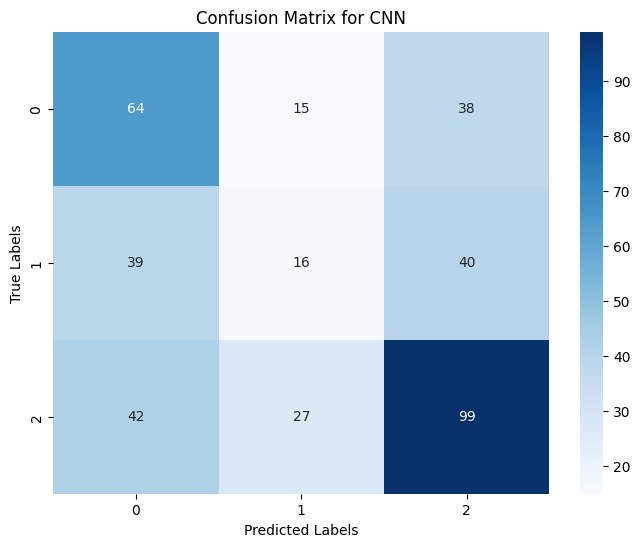

Metrics for FCNN:
Precision: 0.4165, Recall: 0.4209, F1 Score: 0.4148


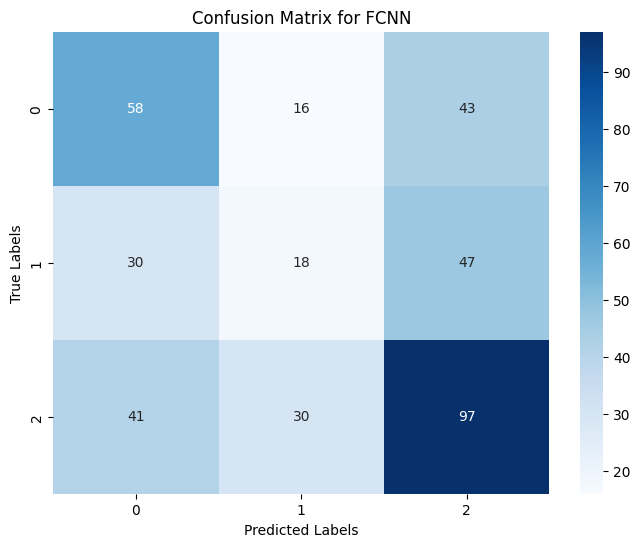

Metrics for SVM:
Precision: 0.3533, Recall: 0.4690, F1 Score: 0.4028


c:\Users\hrzha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


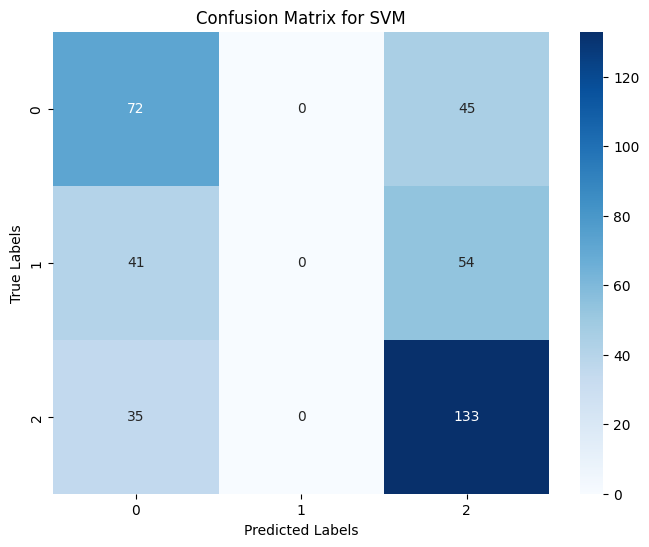

In [149]:
for model, name in [(cnn_model, 'CNN'), (fcnn_model, 'FCNN')]:
    actuals, predictions = get_predictions(model, test_loader)
    display_metrics(actuals, predictions, name)

svm_predictions = svm_model.predict(X_test_svm)
display_metrics(y_test_svm, svm_predictions, 'SVM')

# 2. Regression Models

### 2.1 Split Data

In [150]:
# Load and prepare the data
data = pd.read_csv('final_dataset.csv')
X = data.drop(['Match ID', 'Result', 'Home Goal Difference'], axis=1).values
y = data['Home Goal Difference'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y)

# Create custom dataset
dataset = CustomDataset(X_tensor, y_tensor)

# Define k-fold cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=11)

for fold, (trainval_ids, test_ids) in enumerate(kfold.split(X_tensor)):
    # Create data subsets for training+validation and testing
    trainval_subsampler = Subset(dataset, trainval_ids)
    test_subsampler = Subset(dataset, test_ids)
    
    # Further split training+validation subset into training and validation sets
    validation_split = 0.2
    n_trainval = len(trainval_subsampler)
    n_train = int((1 - validation_split) * n_trainval)
    n_val = n_trainval - n_train
    train_subsampler, val_subsampler = random_split(trainval_subsampler, [n_train, n_val])

    # Define data loaders for training, validation, and testing data in this fold
    train_loader = DataLoader(train_subsampler, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_subsampler, batch_size=64, shuffle=False)

### 2.2 Initialize and Train Models

**Fully Connected Neural Network**

In [151]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [152]:
# Redeifine the FCNN model for regression
class FCNN(nn.Module):
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Only one output neuron for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function for the output layer in regression
        return x

In [153]:
def train(model, criterion, optimizer, loader):
    """Training loop for regression."""
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)  # Adjust for the output dimension
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader):
    """Validation loop for regression."""
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.cpu().numpy())
            truths.extend(labels.cpu().numpy())
    mse = mean_squared_error(truths, predictions)
    rmse = sqrt(mse)
    return rmse

In [154]:
best_val_rmse_across_folds = float('inf')
best_model_state = None

for fold, (trainval_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")

    model = FCNN(input_size=X.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    for epoch in range(1, 101):
        train_loss = train(model, criterion, optimizer, train_loader)
        val_rmse = validate(model, val_loader)

        if val_rmse < best_val_rmse_across_folds:
            best_val_rmse_across_folds = val_rmse
            best_model_state = model.state_dict()

            print(f"Fold {fold+1}, Epoch {epoch}: New best model saved with validation RMSE: {best_val_rmse_across_folds:.4f}")

torch.save(best_model_state, './models/fcnn_regression_best_all_folds.pth')

Fold 1
Fold 1, Epoch 1: New best model saved with validation RMSE: 1.7773
Fold 1, Epoch 2: New best model saved with validation RMSE: 1.7136
Fold 1, Epoch 3: New best model saved with validation RMSE: 1.6863
Fold 1, Epoch 4: New best model saved with validation RMSE: 1.6766
Fold 1, Epoch 5: New best model saved with validation RMSE: 1.6722
Fold 1, Epoch 6: New best model saved with validation RMSE: 1.6698
Fold 1, Epoch 8: New best model saved with validation RMSE: 1.6654
Fold 1, Epoch 10: New best model saved with validation RMSE: 1.6640
Fold 2
Fold 2, Epoch 4: New best model saved with validation RMSE: 1.6636
Fold 2, Epoch 6: New best model saved with validation RMSE: 1.6615
Fold 2, Epoch 7: New best model saved with validation RMSE: 1.6593
Fold 3
Fold 4
Fold 5


**Convolutional Neural Network**

In [155]:
class TabularCNN(nn.Module):
    def __init__(self, num_features):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        feature_size_after_conv = num_features // 2 // 2 * 32

        self.fc1 = nn.Linear(feature_size_after_conv, 128)
        self.fc2 = nn.Linear(128, 1)  # Change for regression: only one output neuron

    def forward(self, x):
        x = x.unsqueeze(1)  # Shape becomes (batch_size, 1, num_features)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation function on the output layer for regression
        return x

In [156]:
best_val_rmse_across_folds = float('inf')
best_model_state = None

for fold, (trainval_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")
    
    model = TabularCNN(num_features=X.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, 101):
        train_loss = train(model, criterion, optimizer, train_loader)
        val_rmse = validate(model, val_loader)

        if val_rmse < best_val_rmse_across_folds:
            best_val_rmse_across_folds = val_rmse
            best_model_state = model.state_dict()

            print(f"Fold {fold+1}, Epoch {epoch}: New best model saved with validation RMSE: {best_val_rmse_across_folds:.4f}")

torch.save(best_model_state, './models/tabular_cnn_regression_best_all_folds.pth')

Fold 1
Fold 1, Epoch 1: New best model saved with validation RMSE: 1.8680
Fold 1, Epoch 2: New best model saved with validation RMSE: 1.7682
Fold 1, Epoch 3: New best model saved with validation RMSE: 1.7175
Fold 1, Epoch 4: New best model saved with validation RMSE: 1.6930
Fold 1, Epoch 6: New best model saved with validation RMSE: 1.6788
Fold 1, Epoch 7: New best model saved with validation RMSE: 1.6785
Fold 1, Epoch 9: New best model saved with validation RMSE: 1.6756
Fold 2
Fold 3
Fold 3, Epoch 8: New best model saved with validation RMSE: 1.6662
Fold 4
Fold 5


**Ridge Regression**

In [157]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

# Prepare the data
X = data.drop(['Match ID', 'Result', 'Home Goal Difference'], axis=1)
y = data['Home Goal Difference']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for ridge regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model and parameters for grid search
model = Ridge()
parameters = {'alpha': np.logspace(-4, 4, 20)}

# Perform grid search
grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)
print("Best RMSE from grid search:", np.sqrt(-grid_search.best_score_))

# Evaluate on the test set
y_pred = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)

# Save the best model
joblib.dump(best_model, './models/ridge_regression_best_model.pkl')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'alpha': 545.5594781168514}
Best RMSE from grid search: 1.7273172432021355
Test RMSE: 1.7386067629033262


['./models/ridge_regression_best_model.pkl']

### 2.3 Model Evaluation

In [158]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load and evaluate the Ridge regression model
ridge_model = joblib.load('./models/ridge_regression_best_model.pkl')

ridge_predictions = ridge_model.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

# Evaluate CNN Model
cnn_model = TabularCNN(num_features=X.shape[1])
state_dict = torch.load('./models/tabular_cnn_regression_best_all_folds.pth')
cnn_model.load_state_dict(state_dict)
cnn_rmse = evaluate_model(cnn_model, test_loader)

# Evaluate FCNN Model
fcnn_model = FCNN(input_size=X.shape[1])
state_dict = torch.load('./models/fcnn_regression_best_all_folds.pth')
fcnn_model.load_state_dict(state_dict)
fcnn_rmse = evaluate_model(fcnn_model, test_loader)

# Display Evaluation Metrics
metrics = pd.DataFrame({
    'Model': ['Ridge Regression', 'CNN', 'FCNN'],
    'RMSE': [ridge_rmse, cnn_rmse, fcnn_rmse],
    'MAE': [ridge_mae, 'N/A', 'N/A'],
    'R²': [ridge_r2, 'N/A', 'N/A']
})

print(metrics)

              Model      RMSE       MAE        R²
0  Ridge Regression  1.738607  1.343207  0.158629
1               CNN  0.250000       N/A       N/A
2              FCNN  0.250000       N/A       N/A
